In [204]:
import os
import pandas as pd
import sys
sys.path.append('/sources')
import matplotlib.pyplot as plt

from preproc import *
from dataset import load_relevant_data_subset

ROOT_PATH = '/sources/dataset/'
df = pd.read_csv(os.path.join(ROOT_PATH, 'train.csv'))

paths = df.path.values
p_ids = df.participant_id.values
s_ids = df.sequence_id.values
labels = df.sign.values

df

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [277]:
easy = ['horse', 'nose', 'bug', 'airplane', 'callonphone']
hard = ['after', 'beside', 'go', 'give', 'look']

easy_idx = []
hard_idx = []
for idx, lb in enumerate(labels):
    if lb in easy:
        easy_idx.append(idx)
    elif lb in hard:
        hard_idx.append(idx)


data_idx = hard_idx[1]

### Raw data

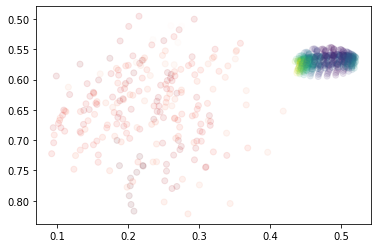

In [278]:


lhand_off = np.array([i for i in range(21)])
rhand_off = np.array([i + 21 for i in range(21)])
lip_off = np.array([i + 42 for i in range(40)])
lip = [
            61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
            291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
            78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
            95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
lhand = [i for i in range(468, 489)]
rhand = [i for i in range(522, 543)]
POSE = lhand + rhand + lip
fig, ax = plt.subplots()
ax.invert_yaxis()


pq_file = f'/sources/dataset/{paths[data_idx]}'
xyz = load_relevant_data_subset(pq_file)

pose = xyz[:,POSE]


ax.scatter(pose[:, lhand_off, 0], pose[:, lhand_off, 1], c=pose[:, lhand_off, 2], alpha=0.1, cmap='Blues')
ax.scatter(pose[:, rhand_off, 0], pose[:, rhand_off, 1], c=pose[:, rhand_off, 2], alpha=0.1, cmap='Reds')
ax.scatter(pose[:, lip_off, 0], pose[:, lip_off, 1], c=pose[:, lip_off, 2], alpha=0.1, cmap='viridis')


plt.show()


### Normalize 1

In [284]:
xyz = load_relevant_data_subset(pq_file)
xyz = torch.from_numpy(xyz)
print(xyz.shape)

torch.Size([14, 543, 3])


tensor([0.3164])


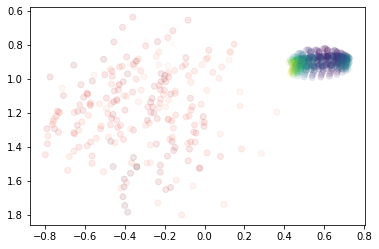

In [285]:
fig, ax = plt.subplots()
ax.invert_yaxis()

xyz= xyz[:, POSE]
mean = xyz[~torch.isnan(xyz)].mean(0, keepdims=True)
print(mean)
norm_gap = xyz - mean  # noramlisation to common maen
norm_std = xyz[~torch.isnan(xyz)].std(0, keepdims=True)
norm_xyz = norm_gap / norm_std

pose = norm_xyz



ax.scatter(pose[:, lhand_off, 0], pose[:, lhand_off, 1],  c=pose[:, lhand_off, 2], alpha=0.1, cmap='Blues')
ax.scatter(pose[:, rhand_off, 0], pose[:, rhand_off, 1],  c=pose[:, rhand_off, 2], alpha=0.1, cmap='Reds')
ax.scatter(pose[:, lip_off, 0], pose[:, lip_off, 1],  c=pose[:, lip_off, 2], alpha=0.1, cmap='viridis')


plt.show()

### Normalize 5

In [292]:
xyz = load_relevant_data_subset(pq_file)
xyz = torch.from_numpy(xyz)
print(xyz.shape)

torch.Size([14, 543, 3])


tensor([ 0.4056,  0.5922, -0.0486])
tensor([0.1217, 0.0523, 0.0434])


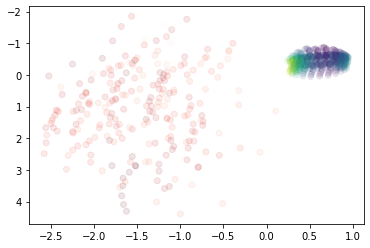

In [293]:
fig, ax = plt.subplots()
ax.invert_yaxis()

xyz = xyz[:, POSE]

valid_mask = ~torch.isnan(xyz)
sum_xyz = torch.nansum(xyz, dim=(0, 1))
count_xyz = torch.sum(valid_mask, dim=(0, 1)).to(torch.float32)

mean_xyz = sum_xyz / count_xyz
print(mean_xyz)

gap = torch.where(valid_mask, xyz - mean_xyz, torch.tensor(float('nan')))
sum_sq_diff = torch.nansum(gap ** 2, dim=(0, 1))
std_xyz = torch.sqrt(sum_sq_diff / count_xyz)
print(std_xyz)

norm_xyz = torch.where(valid_mask, gap / std_xyz, torch.tensor(float('nan')))
pose = norm_xyz

# pose = norm_xyz[:, POSE]

ax.scatter(pose[:, lhand_off, 0], pose[:, lhand_off, 1], c=pose[:, lhand_off, 2], alpha=0.1, cmap='Blues')
ax.scatter(pose[:, rhand_off, 0], pose[:, rhand_off, 1], c=pose[:, rhand_off, 2], alpha=0.1, cmap='Reds')
ax.scatter(pose[:, lip_off, 0], pose[:, lip_off, 1], c=pose[:, lip_off, 2], alpha=0.1, cmap='viridis')

plt.show()

### Normalize 7

In [275]:
xyz = load_relevant_data_subset(pq_file)
xyz = torch.from_numpy(xyz)
print(xyz.shape)


torch.Size([24, 543, 3])


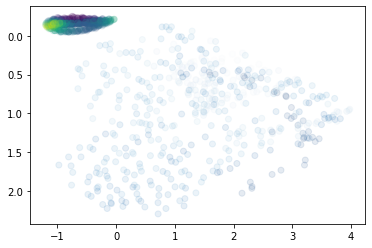

In [276]:
fig, ax = plt.subplots()
ax.invert_yaxis()

valid_mask = ~torch.isnan(xyz)

mean_xyz = torch.tensor([0.4706, 0.4606, -0.0453])
std_xyz = torch.tensor([0.1036, 0.2405, 0.3024])

gap = torch.where(valid_mask, xyz - mean_xyz, torch.tensor(float('nan')))

norm_xyz = torch.where(valid_mask, gap / std_xyz, torch.tensor(float('nan')))

pose = norm_xyz[:, POSE]

ax.scatter(pose[:, lhand_off, 0], pose[:, lhand_off, 1], c=pose[:, lhand_off, 2], alpha=0.1, cmap='Blues')
ax.scatter(pose[:, rhand_off, 0], pose[:, rhand_off, 1], c=pose[:, rhand_off, 2], alpha=0.1, cmap='Reds')
ax.scatter(pose[:, lip_off, 0], pose[:, lip_off, 1], c=pose[:, lip_off, 2], alpha=0.1, cmap='viridis')

plt.show()


### Normalize 8

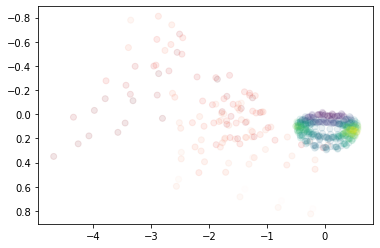

In [264]:
fig, ax = plt.subplots()
ax.invert_yaxis()

valid_mask = ~torch.isnan(xyz)

sum_xy = torch.nansum(xyz[:, :, :2], dim=(0, 1))
sum_lip_z = torch.nansum(xyz[:, lip, -1], dim=(0, 1))
sum_lhand_z = torch.nansum(xyz[:, lhand, -1], dim=(0, 1))
sum_rhand_z = torch.nansum(xyz[:, rhand, -1], dim=(0, 1))

count_xy = torch.sum(valid_mask[:, :, :2], dim=(0, 1)).to(torch.float32)
count_lip_z = torch.sum(valid_mask[:, lip, -1], dim=(0, 1)).to(torch.float32)
count_lhand_z = torch.sum(valid_mask[:, lhand, -1], dim=(0, 1)).to(torch.float32)
count_rhand_z = torch.sum(valid_mask[:, rhand, -1], dim=(0, 1)).to(torch.float32)

mean_xy = sum_xy / count_xy
mean_lip_z = sum_lip_z / count_lip_z
mean_lhand_z = sum_lhand_z / count_lhand_z
mean_rhand_z = sum_rhand_z / count_rhand_z

gap_xy = torch.where(valid_mask[:, :, :2], xyz[:, :, :2] - mean_xy, torch.tensor(float('nan')))
sum_sq_diff_xy = torch.nansum(gap_xy ** 2, dim=(0, 1))
std_xy = torch.sqrt(sum_sq_diff_xy / count_xy)

gap_lip_z = torch.where(valid_mask[:, lip, -1], xyz[:, lip, -1] - mean_lip_z, torch.tensor(float('nan')))
gap_lhand_z = torch.where(valid_mask[:, lhand, -1], xyz[:, lhand, -1] - mean_lhand_z, torch.tensor(float('nan')))
gap_rhand_z = torch.where(valid_mask[:, rhand, -1], xyz[:, rhand, -1] - mean_rhand_z, torch.tensor(float('nan')))
sum_sq_diff_lip_z = torch.nansum(gap_lip_z ** 2, dim=(0, 1))
sum_sq_diff_lhand_z = torch.nansum(gap_lhand_z ** 2, dim=(0, 1))
sum_sq_diff_rhand_z = torch.nansum(gap_rhand_z ** 2, dim=(0, 1))
std_lip_z = torch.sqrt(sum_sq_diff_lip_z / count_lip_z)
std_lhand_z = torch.sqrt(sum_sq_diff_lhand_z / count_lhand_z)
std_rhand_z = torch.sqrt(sum_sq_diff_rhand_z / count_rhand_z)


norm_xy = torch.where(valid_mask[:, :, :2], gap_xy / std_xy, torch.tensor(float('nan')))
norm_lip_z = torch.where(valid_mask[:, lip, -1], gap_lip_z / std_lip_z, torch.tensor(float('nan')))
norm_lhand_z = torch.where(valid_mask[:, lhand, -1], gap_lhand_z / std_lhand_z, torch.tensor(float('nan')))
norm_rhand_z = torch.where(valid_mask[:, rhand, -1], gap_rhand_z / std_rhand_z, torch.tensor(float('nan')))


pose = norm_xy[:, POSE]
pose_z = torch.cat((norm_lhand_z, norm_rhand_z, norm_lip_z), dim=-1)
pose = torch.cat((pose, pose_z.unsqueeze(-1)), dim=-1)

ax.scatter(pose[:, lhand_off, 0], pose[:, lhand_off, 1], c=pose[:, lhand_off, 2], alpha=0.1, cmap='Blues')
ax.scatter(pose[:, rhand_off, 0], pose[:, rhand_off, 1], c=pose[:, rhand_off, 2], alpha=0.1, cmap='Reds')
ax.scatter(pose[:, lip_off, 0], pose[:, lip_off, 1], c=pose[:, lip_off, 2], alpha=0.1, cmap='viridis')

plt.show()


### Normalize 6

In [265]:
xyz = load_relevant_data_subset(pq_file)
xyz = torch.from_numpy(xyz)
print(xyz.shape)

torch.Size([9, 543, 3])


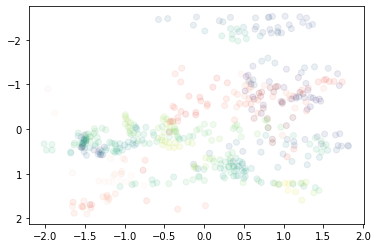

In [266]:
fig, ax = plt.subplots()
ax.invert_yaxis()

valid_mask = ~torch.isnan(xyz)
sum_xyz = torch.nansum(xyz, dim=(0))
count_xyz = torch.sum(valid_mask, dim=(0)).to(torch.float32)

mean_xyz = sum_xyz / count_xyz

gap = torch.where(valid_mask, xyz - mean_xyz, torch.tensor(float('nan')))
sum_sq_diff = torch.nansum(gap ** 2, dim=(0))
std_xyz = torch.sqrt(sum_sq_diff / count_xyz)

norm_xyz = torch.where(valid_mask, gap / std_xyz, torch.tensor(float('nan')))

pose = norm_xyz[:, POSE]

ax.scatter(pose[:, lhand_off, 0], pose[:, lhand_off, 1], c=pose[:, lhand_off, 2], alpha=0.1, cmap='Blues')
ax.scatter(pose[:, rhand_off, 0], pose[:, rhand_off, 1], c=pose[:, rhand_off, 2], alpha=0.1, cmap='Reds')
ax.scatter(pose[:, lip_off, 0], pose[:, lip_off, 1], c=pose[:, lip_off, 2], alpha=0.1, cmap='viridis')

plt.show()